## Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import tensorflow as tf
import config

In [2]:
with open("data/icwb2-data/training/msr_training.utf8",encoding="utf-8") as f:
    msr_training=f.readlines()
print("How many lines in ",len(msr_training))

How many lines in  86924


## Tagging

In [3]:
from pprint import pprint 
msr_training_tagged=[]
for line in msr_training:
    word_list = line.strip().split()
    tag=[]
    for word in word_list:
        if len(word) == 1:
            tag.append("S")
        else:
            tag.append("B"+"M"*len(word[1:-1])+"E")
    msr_training_tagged.append((word_list,tag))
print(msr_training_tagged[0][0][:])
print(msr_training_tagged[0][1][:])

['“', '人们', '常', '说', '生活', '是', '一', '部', '教科书', '，', '而', '血', '与', '火', '的', '战争', '更', '是', '不可多得', '的', '教科书', '，', '她', '确实', '是', '名副其实', '的', '‘', '我', '的', '大学', '’', '。']
['S', 'BE', 'S', 'S', 'BE', 'S', 'S', 'S', 'BME', 'S', 'S', 'S', 'S', 'S', 'S', 'BE', 'S', 'S', 'BMME', 'S', 'BME', 'S', 'S', 'BE', 'S', 'BMME', 'S', 'S', 'S', 'S', 'BE', 'S', 'S']


## Making Dictionary

In [4]:
word_count = dict()
for text, tag in msr_training_tagged:
    for word in text :
        if word not in word_count:
            word_count[word] = 1
        else :
            word_count[word]+=1
pd.Series(word_count).sort_values(ascending=False)

，         173174
的         128147
。          81766
、          40696
在          28445
           ...  
血库             1
巴拉那河流域         1
第二百次           1
为患             1
仝丽             1
Length: 88119, dtype: int64

In [5]:
char_count={}
for text, tag in msr_training_tagged:
    for char in "".join(text):
        if char not in char_count: char_count[char]=1
        else: char_count[char]+=1
char_dict = {} 
char_dict["pad"]=0
char_dict["unk"]=1
for i, char in enumerate(char_count.keys()):
    char_dict[char] = i+2 
char_size=len(char_dict )
print("char_size: ",char_size)

char_size:  5169


## Preparing Train, Val, Test Dataset

In [6]:
longest=0

x_train=[]
for text,tag in msr_training_tagged:
    temp=[ char_dict[char] for char in "".join(text)]
    if len(temp) > longest : longest = len(temp)

print(longest)
for text,tag in msr_training_tagged:
    temp=[ char_dict[char] for char in "".join(text)]
    if len(temp) < longest : temp+=[0]*(longest-len(temp))
    x_train.append(temp)
x_train = np.array(x_train)
x_train.shape

581


(86924, 581)

In [7]:
tag_map={"S":[1,0,0,0],"B":[0,1,0,0],"M":[0,0,1,0],"E":[0,0,0,1]}
y_train=[]
for text,tag in msr_training_tagged:
    temp=[ tag_map[tag] for tag in "".join(tag)]
    if len(temp) < longest : temp += [[0,0,0,0]]*(longest-len(temp))
    y_train.append(temp)
y_train = np.array(y_train)
y_train.shape    

(86924, 581, 4)

In [8]:
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

## Model

### Configure

In [54]:
import tensorflow as tf
import config

ModuleNotFoundError: No module named 'config'

In [37]:
batch_size = 20
sequence_size = longest
embedding_dim = 100
drop_rate = 0.2 
file_name = "BiGRU"
GRU_dim=32
epochs = 15
workers = 8

### Model-Building

In [38]:
tf.keras.backend.clear_session()
input_ = tf.keras.layers.Input((None,))
output_ = tf.keras.layers.Embedding(input_dim=char_size, output_dim=embedding_dim, mask_zero=True)(input_)
output_ = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_dim, return_sequences=True), 
                               input_shape=(sequence_size, embedding_dim))(output_)
output_ = tf.keras.layers.Dropout(drop_rate)(output_)
output_ = tf.keras.layers.Dense(4,activation="sigmoid")(output_)
model = tf.keras.Model(input_, output_)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         516900    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          25728     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense (Dense)                (None, None, 4)           260       
Total params: 542,888
Trainable params: 542,888
Non-trainable params: 0
_________________________________________________________________


### Model Compile

In [39]:
model.compile('adam', 'categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),
                                                          tf.keras.metrics.BinaryAccuracy()])

### Model Training & Save

In [40]:
print('Train...')
History = model.fit(
                x=x_train, y=y_train, 
                validation_data=(x_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                workers=workers,
                )
model.reset_metrics()
model.save("{}.h5".format(file_name))

Train...
Train on 81924 samples, validate on 5000 samples
Epoch 1/15
81924/81924 [==============================] - 1303s 16ms/sample - loss: 0.0315 - categorical_accuracy: 0.8556 - binary_accuracy: 0.8347 - val_loss: 0.0256 - val_categorical_accuracy: 0.8844 - val_binary_accuracy: 0.8139
Epoch 2/15
81924/81924 [==============================] - 1302s 16ms/sample - loss: 0.0221 - categorical_accuracy: 0.9017 - binary_accuracy: 0.8178 - val_loss: 0.0225 - val_categorical_accuracy: 0.8996 - val_binary_accuracy: 0.8048
Epoch 3/15
81924/81924 [==============================] - 1454s 18ms/sample - loss: 0.0193 - categorical_accuracy: 0.9147 - binary_accuracy: 0.8110 - val_loss: 0.0207 - val_categorical_accuracy: 0.9084 - val_binary_accuracy: 0.8023
Epoch 4/15
81924/81924 [==============================] - 1338s 16ms/sample - loss: 0.0175 - categorical_accuracy: 0.9230 - binary_accuracy: 0.8081 - val_loss: 0.0194 - val_categorical_accuracy: 0.9145 - val_binary_accuracy: 0.8038
Epoch 5/15
819

OSError: Unable to create file (unable to open file: name = 'BiGRU.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [56]:
model.save("BiGRU.h5")

OSError: Unable to create file (unable to open file: name = 'BiGRU.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

## Model loss plot

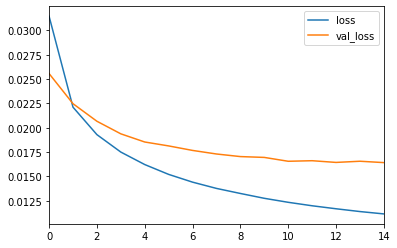

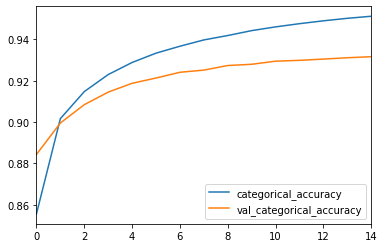

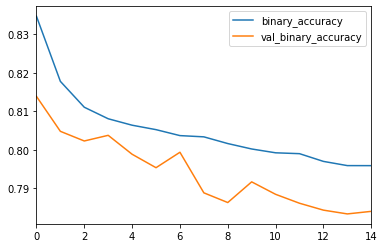

In [41]:
pd.DataFrame(History.history)[["loss","val_loss"]].plot()
pd.DataFrame(History.history)[["categorical_accuracy","val_categorical_accuracy"]].plot()
pd.DataFrame(History.history)[["binary_accuracy","val_binary_accuracy"]].plot()

# Test

## Load model

In [3]:
model=tf.keras.models.load_model("BiGRU.h5")

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         516900    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          25728     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense (Dense)                (None, None, 4)           260       
Total params: 542,888
Trainable params: 542,888
Non-trainable params: 0
_________________________________________________________________


In [6]:
# model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': True,
    'batch_input_shape': (None, None),
    'dtype': 'float32',
    'input_dim': 5169,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': True,
    'input_length': None},
   'name': 'embedding',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'batch_input_shape': (None, 581, 100),
    'dtype': 'float32',
    'layer': {'class_name': 'GRU',
     '

In [10]:
dir()

['In',
 'NamespaceMagics',
 'Out',
 '_',
 '_5',
 '_6',
 '_7',
 '_8',
 '_Jupyter',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_getshapeof',
 '_getsizeof',
 '_i',
 '_i1',
 '_i10',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_nms',
 '_oh',
 'config',
 'exit',
 'get_ipython',
 'getsizeof',
 'json',
 'model',
 'np',
 'pd',
 'plt',
 'px',
 'quit',
 'tf',
 'var_dic_list',
 'xxxxx']

## Load test file 

In [35]:
with open("data/icwb2-data/gold/msr_test_gold.utf8",encoding="utf-8") as f:
    msr_test=f.readlines()
print("How many lines in ",len(msr_test))

How many lines in  3985


In [36]:
from pprint import pprint 
msr_test_tagged=[]
for line in msr_test:
    word_list = line.strip().split()
    tag=[]
    for word in word_list:
        if len(word) == 1:
            tag.append("S")
        else:
            tag.append("B"+"M"*len(word[1:-1])+"E")
    msr_test_tagged.append((word_list,tag))
print(msr_test_tagged[5][0][:])
print(msr_test_tagged[5][1][:])

['十几年', '来', '，', '改革开放', '的', '中国', '经济', '高速', '发展', '，', '远东', '在', '崛起', '。']
['BME', 'S', 'S', 'BMME', 'S', 'BE', 'BE', 'BE', 'BE', 'S', 'BE', 'S', 'BE', 'S']


In [37]:
x_test=[]

for text,tag in msr_test_tagged:
    temp=[ char_dict[char] if char in char_dict else char_dict["unk"] for char in "".join(text)]
    if len(temp) < longest : temp+=[0]*(longest-len(temp))
    x_test.append(temp)
x_test = np.array(x_test)
x_test.shape

(3985, 581)

In [38]:
tag_map={"S":[1,0,0,0],"B":[0,1,0,0],"M":[0,0,1,0],"E":[0,0,0,1]}
y_test=[]
for text,tag in msr_test_tagged:
    temp=[ tag_map[tag] for tag in "".join(tag)]
    if len(temp) < longest : temp += [[0,0,0,0]]*(longest-len(temp))
    y_test.append(temp)
y_test = np.array(y_test)
y_test.shape

(3985, 581, 4)

In [39]:
text_len=[]
for text,tag in msr_test_tagged:
    text_len.append(len("".join(tag)))

In [40]:
model.reset_metrics()
model.evaluate(x=x_test,y=y_test)

3985/3985 [==============================] - 6s 1ms/sample - loss: 0.0146 - categorical_accuracy: 0.9387 - binary_accuracy: 0.7873


[0.014562425545534795, 0.9387486, 0.7872623]

In [41]:
y_predict = model.predict(x_test)

## Metrics - Precision, Recall, F-scores

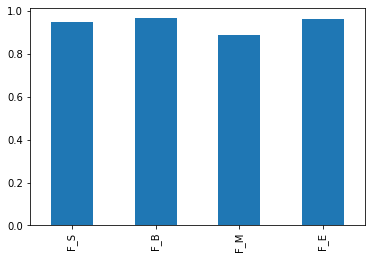

In [49]:
class word_segment_metrics:
    def __init__(self,y_predict,y_true,text_len):
        self.y_predict_flat, self.y_true_flat = self.flatten_and_truncat(y_predict,y_true,text_len)
        self.prf = self.prf_calculator()
        
    def flatten_and_truncat(self,y_predict,y_true,text_len):
        y_predict_flat = []
        y_true_flat = []
        for row_predict,row_true,size in zip(y_predict.argmax(-1),y_true.argmax(-1),text_len):
            y_predict_flat+=row_predict[:size].tolist()
            y_true_flat+=row_true[:size].tolist()   
        return np.array(y_predict_flat), np.array(y_true_flat)
    def prf_calculator(self):
        p_pred_S=len(self.y_predict_flat[self.y_predict_flat==0])
        p_true_S = len(self.y_true_flat[self.y_true_flat==0])
        tp_S = len(self.y_predict_flat[(self.y_predict_flat==0) *(self.y_true_flat==0)])
        P_S=tp_S/p_pred_S
        R_S=tp_S/p_true_S
        F_S = 2*((P_S*R_S)/(P_S+R_S))
        
        p_pred_B=len(self.y_predict_flat[self.y_predict_flat==1])
        p_true_B = len(self.y_true_flat[self.y_true_flat==1])
        tp_B = len(self.y_predict_flat[(self.y_predict_flat==1) *(self.y_true_flat==1)])
        P_B=tp_B/p_pred_B
        R_B=tp_B/p_true_B
        F_B = 2*((P_B*R_B)/(P_B+R_B))

        p_pred_M=len(self.y_predict_flat[self.y_predict_flat==2])
        p_true_M = len(self.y_true_flat[self.y_true_flat==2])
        tp_M = len(self.y_predict_flat[(self.y_predict_flat==2) *(self.y_true_flat==2)])
        P_M=tp_M/p_pred_M
        R_M=tp_M/p_true_M
        F_M = 2*((P_M*R_M)/(P_M+R_M))

        p_pred_E=len(self.y_predict_flat[self.y_predict_flat==3])
        p_true_E = len(self.y_true_flat[self.y_true_flat==3])  
        tp_E = len(self.y_predict_flat[(self.y_predict_flat==3) *(self.y_true_flat==3)])
        P_E=tp_E/p_pred_E
        R_E=tp_E/p_true_E
        F_E = 2*((P_E*R_E)/(P_E+R_E))

        return {
            "P_S":P_S, "P_B":P_B, "P_M":P_M, "P_E":P_E,
            "R_S":R_S, "R_B":R_B, "R_M":R_M, "R_E":R_E,
            "F_S":F_S, "F_B":F_B, "F_M":F_M, "F_E":F_E,
               }
ws_metrics=word_segment_metrics(y_predict,y_test,text_len)
pd.Series(ws_metrics.prf)[:4].plot(kind="bar")
pd.Series(ws_metrics.prf)[4:8].plot(kind="bar")
pd.Series(ws_metrics.prf)[8:12].plot(kind="bar")